# Validation of the PyPSA-Earth stats

## Description
This task aims to develop such notebook that:
- takes as input the files from folders from pypsa-earth: `results/{scenarios}/stats.csv` (see PR Create statistics #579). In the meantime, data is loaded from `notebooks/validation/temp_stats_csv/stats_merged_20_3_23.csv`
- loads open data on power systems across the world
- Creates plots to perform the validation
Plots and tables shall have different aggregation levels (e.g. demand for a continent)

Create statistics for:
- demand (See `demand_validation.ipynb`)
- installed capacity by technology (compare with: IRENA, ...)
- renewable sources  (compare with: IRENA, ...)
- network characteristics (length of lines for example, https://wiki.openmod-initiative.org/wiki/Transmission_network_datasets)

Plots:
- Compare the statistics of the PyPSA-Earth model with open data

## Public data sources collection
These sources could be helpful:
- [ENTSO-E](https://transparency.entsoe.eu/generation/r2/installedGenerationCapacityAggregation/show)
- [IRENA](https://www.irena.org/data-and-statistics), not working
- [IEA](https://www.iea.org/data-and-statistics)
    - Electricity demand: https://www.iea.org/data-and-statistics/data-product/world-energy-balances-highlights
- [WEC](https://www.worldenergy.org/statistics/), not working
- [WRI](https://www.wri.org/resources/data-sets)
- [UN](https://unstats.un.org/unsd/snaama/)
- [WBG](https://datacatalog.worldbank.org/dataset/world-development-indicators)
- [OECD](https://data.oecd.org/)
- [Eurostat](https://ec.europa.eu/eurostat/data/database)
- [EIA](https://www.eia.gov/outlooks/aeo/data/browser/)
- [Enerdata](https://www.enerdata.net/research/)
- [BP](https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy.html)
- [USAID](https://www.usaid.gov/what-we-do/energy/global-energy-database), Single countries only?

https://www.usaid.gov/powerafrica/nigeria


## TODO
- DONE: Include continent analysis with country converter coco
- DONE: Continent `Asia` shows high ror and low hydro in PyPSA-Earth, but low ror and high hydro in IRENA. Why? Technology mismatch?
- Include stats on how many of the countries of a specific continent are in the PyPSA-Earth model, to better compare continental data. coco could be helpful here. Is this necessary?
- Fossil fuels as oil, gas, coal are often summed up as 'Fossil fuels n.e.s' in Europe which means 'not elsewhere specified' in IRENA data. How to deal with this?

## Questions
- 

## Preparation

### Import packages

In [1]:
import logging
import os
import sys

import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import country_converter as coco

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

In [2]:
nice_names = {
    "nuclear": "Nuclear",
    "oil": "Oil",
    "onwind": "Onshore wind",
    #"ror": "Run of river",
    "solar": "Solar PV",
    "hydro": "Hydro",
    "gas": "Gas",
    "coal_and_lignite": "Coal",
}

### Set main directory to root folder

In [3]:
# change current directory
module_path = os.path.abspath(os.path.join('../../../')) # To import helpers

if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
from _helpers import sets_path_to_root, country_name_2_two_digits, two_digits_2_name_country

sets_path_to_root("documentation")

This is the repository path:  /mnt/c/Users/scl38887/Documents/git/documentation
Had to go 2 folder(s) up.


### Load stats data (obtained from pypsa-earth)

In [4]:
# Read it with multilevel column names. Make sure that the country index "NA" is not recognized as NaN
stats = pd.read_csv("notebooks/validation/temp_stats_csv/stats_merged_07_04_23.csv", index_col=0, header=[0,1], keep_default_na=False, na_values="")

### Load public data

In [5]:
EXAMPLE_URL="https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/"

In [6]:
# Read the data "https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/"
# TODO can we download the data directly?
irena_eleccap = pd.read_csv("notebooks/validation/temp_irena/ELECCAP_20230314-165057.csv", encoding="latin-1", skiprows=2)

# Replace ".." in the dataframe with NaN
irena_eleccap = irena_eleccap.replace("..", np.nan)

# Change dtype of column "Installed electricity capacity by country/area (MW)" to float
irena_eleccap["Installed electricity capacity by country/area (MW)"] = irena_eleccap["Installed electricity capacity by country/area (MW)"].astype(float)

In [7]:
# Combine ongrid and offgrid
irena_eleccap = irena_eleccap.groupby(["Country/area", "Year", "Technology"]).sum(numeric_only=True).reset_index() #"Technology", "Installed electricity capacity by country/area (MW)"

# Delete the column "Year" since it is not needed anymore
irena_eleccap = irena_eleccap.drop(columns=["Year"])

In [8]:
# Check data for a single country
irena_eleccap[irena_eleccap["Country/area"] == "Germany"].head(5)

,Country/area,Technology,Installed electricity capacity by country/area (MW)
1482,Germany,Biogas,7611.0
1483,Germany,Coal and peat,0.0
1484,Germany,Fossil fuels n.e.s.,78335.0
1485,Germany,Geothermal energy,40.0
1486,Germany,Liquid biofuels,231.0


## Validation

### Installed capacity by technology

In [9]:
# Define the technologies which should be compared
techs = ["CCGT", "OCGT", "nuclear", "onwind", "solar", "ror",  "hydro", "oil", "coal", "lignite"]

# Select rule "add_electricity" and their techs 
stats_capacities = stats["add_electricity"].loc[:, (techs)]

# Add continent at the beginning of the dataframe
stats_capacities.insert(0, "continent", coco.convert(names = stats_capacities.index, src = 'ISO2', to = 'continent'))

# Replace NaN with zeros
stats_capacities = stats_capacities.fillna(0)

CP not found in ISO2
IC not found in ISO2
XS not found in ISO2
XD not found in ISO2


In [10]:
# Combine CCGT and OCGT to "gas"
stats_capacities["gas"] = stats_capacities["CCGT"] + stats_capacities["OCGT"]
stats_capacities["coal_and_lignite"] = stats_capacities["coal"] + stats_capacities["lignite"]
stats_capacities["hydro"] = stats_capacities["ror"] + stats_capacities["hydro"]
del stats_capacities["CCGT"] 
del stats_capacities["OCGT"] # TODO write in one line
del stats_capacities["coal"] 
del stats_capacities["lignite"]
del stats_capacities["ror"]

In [11]:
# Rename to nice plotting names
stats_capacities.rename(columns=nice_names, inplace=True)

In [12]:
# Add a empty column "Fossil fuels n.e.s"
stats_capacities["Fossil fuels n.e.s."] = 0

In [13]:
stats_capacities.head()

key,continent,Nuclear,Onshore wind,Solar PV,Hydro,Oil,Gas,Coal,Fossil fuels n.e.s.
GR,Europe,0.00000,4112.721421,3246.949798,4094.085465,3347.852100,3341.886724,4762.852463,0
KR,Asia,24606.11848,1498.721628,14574.790000,2210.881656,5854.440331,31683.149293,30016.403447,0
SZ,Africa,0.00000,0.000000,0.131667,77.817608,0.000000,0.000000,0.000000,0
IL,Asia,0.00000,26.831003,2230.000000,0.000000,4824.355260,4748.080542,4462.174870,0
ID,Asia,0.00000,144.348258,156.317124,4451.367922,16442.561168,12810.000000,30805.445305,0


#### Uniform technology names and dataframe structure

In [14]:
# Create dict to match the technology names of stats_capacities and irena eleccap
uniform_names = {"Solar photovoltaic": "solar",
        "Onshore wind energy": "onwind",
        #"Offshore wind energy": "offwind",
        "Renewable hydropower": "hydro",
        "Nuclear": "nuclear",
        "Oil": "oil",
        "Natural gas": "gas",
        "Mixed Hydro Plants": "ror", # TODO Is this correct? Check IRENA    
        "Coal and peat": "coal_and_lignite",
        }

In [15]:
# Rename the technologies in irena_eleccap to match the names in stats_capacities using the dict names
irena_eleccap["Technology"] = irena_eleccap["Technology"].replace(uniform_names)

# Transform technologies to columns and have the countries as index
irena_eleccap = irena_eleccap.pivot_table(index=["Country/area"], columns="Technology", values="Installed electricity capacity by country/area (MW)")
# Reset name of columns
irena_eleccap.columns.name = None

# Combine the columns ror and hydro and name them hydro
irena_eleccap["hydro"] = irena_eleccap["ror"] + irena_eleccap["hydro"]
del irena_eleccap["ror"]

In [16]:
# Change the index of irena_eleccap to two digit country name using the function country_name_2_two_digits()
irena_eleccap.index = irena_eleccap.index.map(country_name_2_two_digits)

In [17]:
# Add continent at the beginning of the dataframe
irena_eleccap.insert(0, "continent", coco.convert(names = irena_eleccap.index, src = 'ISO2', to = 'continent'))

# Rename to nice plotting names
irena_eleccap.rename(columns=nice_names, inplace=True)

#### Plot country comparison

In [18]:
def plot_barplot(data_stats, data_irena, area, title=False):
    # Plot a barplot to compare the technologies of the two dataframes irena_eleccap and stats_capacities

    # Get the index values
    index = np.arange(len(data_stats))
    barWidth = 0.3

    # Create a barplot
    plt.figure(figsize=(6, 3))
    plt.bar(index - barWidth/2, data_stats/1e3, color=['g'], alpha=1, edgecolor='white', width=barWidth) # convert from MW to GW
    plt.bar(index + barWidth/2, data_irena/1e3, color=['g'], alpha=0.3, edgecolor='white', width=barWidth) # convert from MW to GW

    # Enhance graph
    plt.xticks(index, data_stats.index)
    plt.ylabel("Capacity in GW")
    plt.legend(["PyPSA-Earth", "IRENA"], loc='upper left', ncol=1)

    plt.grid(axis='y', alpha=0.5)
    if title == True:
        if area == "Global":
            plt.title(f"Electric capacity ({area})")
        else:
            plt.title(f"Electric capacity in {area}")

    # Show graphic & save it
    plt.savefig(f"notebooks/validation/temp_results/el_cap_{area}.pdf", bbox_inches='tight') # TODO add save path
    plt.show()
    
    return

In [19]:
def is_country_or_continent(area_name):

    # Check if the area name is a valid ISO-3166 country code

    area_name = coco.convert(names=area_name, to='name_short')
    if area_name != "not found":
        return "country"
    else:
        return "continent" # TODO all invalid names are continents, this should be improved


In [20]:
def area_selection(area, stats_capacities, irena_eleccap, group_fossils=False):

    _stats_capacities = stats_capacities.copy()
    _irena_eleccap = irena_eleccap.copy()

    if area == "Global":
        _stats_capacities = _stats_capacities.sum(axis=0).to_frame().T #.rename(columns={"continent": "PyPSA-Earth"})
        _stats_capacities["continent"] = "Global"
        _stats_capacities.set_index("continent", inplace=True)

        _irena_eleccap = _irena_eleccap.sum(axis=0).to_frame().T #.rename(columns={"continent": "PyPSA-Earth"})
        _irena_eleccap["continent"] = "Global"
        _irena_eleccap.set_index("continent", inplace=True)

    elif area != "Global":
        if is_country_or_continent(area) == "continent":

            # Group the data by continent if area is "continent"
            _irena_eleccap = _irena_eleccap.groupby("continent").sum()
            _stats_capacities = _stats_capacities.groupby("continent").sum()

        elif is_country_or_continent(area) == "country":
            try:
                _irena_eleccap.drop(columns=["continent"], inplace=True)
                _stats_capacities.drop(columns=["continent"], inplace=True)
            except:
                pass

    # Select the data for the area
    data_irena = _irena_eleccap.loc[area][_stats_capacities.loc[area].index]
    data_stats = _stats_capacities.loc[area]

    if group_fossils == True:
        data_stats["Fossil fuels"] = data_stats["Oil"] + data_stats["Gas"] + data_stats["Coal"] + data_stats["Fossil fuels n.e.s."]
        data_stats = data_stats.drop(["Oil", "Gas", "Coal", "Fossil fuels n.e.s."])
        data_irena["Fossil fuels"] = data_irena["Oil"] + data_irena["Gas"] + data_irena["Coal"] + data_irena["Fossil fuels n.e.s."]
        data_irena = data_irena.drop(["Oil", "Gas", "Coal", "Fossil fuels n.e.s."])

    return data_stats, data_irena

### Plot comparison (both country or continent possible)

Single country, continent, or global

/tmp/ipykernel_814/61637356.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_814/61637356.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



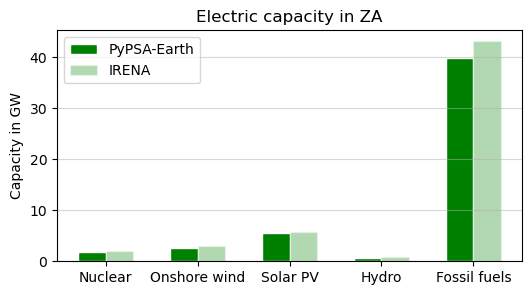

In [62]:
area = "ZA"
data_stats, data_irena = area_selection(area, stats_capacities, irena_eleccap, group_fossils=True)
plot_barplot(data_stats, data_irena, area, title= True)

In [22]:
(data_stats/1000).head(10)

key
Nuclear           1.777943
Onshore wind     17.188084
Solar PV          7.864614
Hydro           109.456632
Fossil fuels     29.358125
Name: BR, dtype: float64

In [23]:
(data_irena/1000).head(10)

key
Nuclear           1.990000
Onshore wind     21.161270
Solar PV         13.054926
Hydro           109.426250
Fossil fuels     30.078687
Name: BR, dtype: float64

All continents

Europe not found in regex
/tmp/ipykernel_814/61637356.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_814/61637356.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



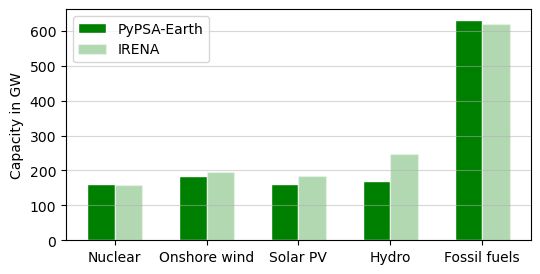

Asia not found in regex


Fossil fuels as oil, gas, coal are often summed up as 'Fossil fuels n.e.s' in Europe which means 'not elsewhere specified' in IRENA data.


/tmp/ipykernel_814/61637356.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_814/61637356.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



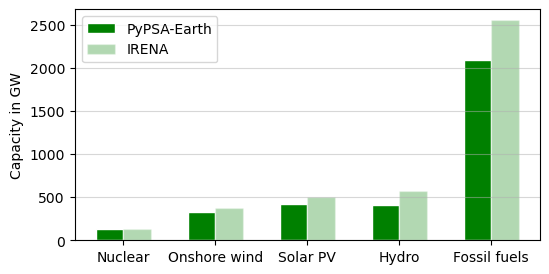

Africa not found in regex
/tmp/ipykernel_814/61637356.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_814/61637356.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



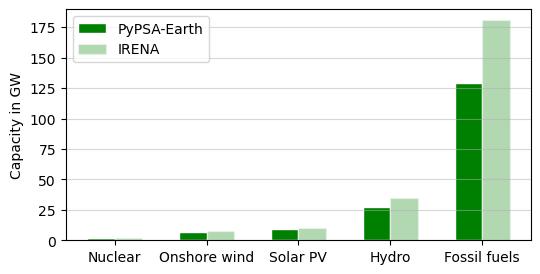

Oceania not found in regex
/tmp/ipykernel_814/61637356.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_814/61637356.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



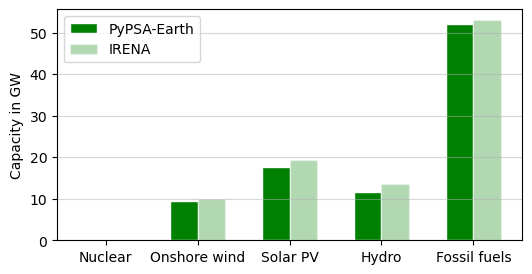

America not found in regex
/tmp/ipykernel_814/61637356.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_814/61637356.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



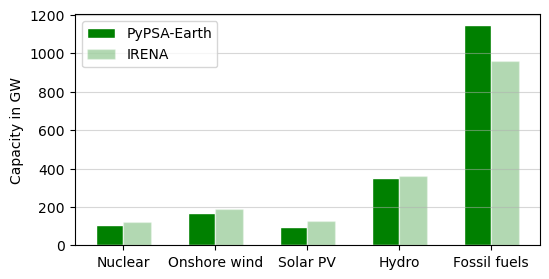

In [24]:
# Plot and save all continents
areas = stats_capacities.continent.unique()
areas = areas[areas != "not found"]
for area in areas:
    data_stats, data_irena = area_selection(area, stats_capacities, irena_eleccap, group_fossils=True)
    plot_barplot(data_stats, data_irena, area)
    if area == "Europe":
        print("Fossil fuels as oil, gas, coal are often summed up as 'Fossil fuels n.e.s' in Europe which means 'not elsewhere specified' in IRENA data.")

### Demand

In [25]:
stats.head()

rule download_osm_data                                                         \
key        cables-size generators-size lines-size substations-size total_time   
GR                41.0          8172.0     1189.0            427.0     5.2221   
KR               187.0          3962.0     2968.0            916.0     5.3489   
SZ                 1.0            55.0       58.0             28.0     1.6636   
IL                50.0           663.0      799.0            198.0     2.4618   
ID                30.0          1123.0     2425.0           2451.0     6.5828   

rule                       clean_osm_data                           \
key  mean_load max_memory generators-size lines-size lines-size_dc   
GR       77.78     694.51            67.0      997.0           3.0   
KR       71.49     695.32           111.0     3007.0           0.0   
SZ        8.30     461.60             NaN       45.0           0.0   
IL       30.15     611.57            22.0       61.0           0.0   
ID       78.10     773.86           268.0     2143.0           0.0   

rule                                                                      \
key   lines-length lines-length_dc substations-size total_time mean_load   
GR    2.131592e+07   135770.035577           1996.0     7.9456     88.73   
KR    3.476824e+07        0.000000           6111.0    21.9648     71.71   
SZ    6.164592e+05        0.000000             94.0     0.8904      0.00   
IL    1.575221e+06        0.000000            122.0     1.1340      0.00   
ID    5.294945e+07        0.000000           4660.0    68.7576     66.51   

rule             build_shapes                                           \
key  max_memory          area gadm_size country_matching           pop   
GR       529.48  6.257667e+11       8.0            100.0  1.038533e+07   
KR       524.91  5.331273e+11      17.0            100.0  5.133817e+07   
SZ       511.70  2.338520e+10       4.0            100.0  1.161682e+06   
IL       512.00  5.721127e+10       7.0            100.0  8.686033e+06   
ID       526.99  7.979211e+12      34.0            100.0  2.734488e+08   

rule                                               build_bus_regions  \
key            gdp total_time mean_load max_memory         n_onshore   
GR    2.917581e+11    32.7742     49.11    1000.40             277.0   
KR    2.394653e+12    32.6975     48.35     997.62             485.0   
SZ    1.389325e+10    22.2803     71.47    1008.84              15.0   
IL    4.187760e+11    23.1516     69.36    1009.09              40.0   
ID    2.986296e+12   509.8633    238.17   94265.92             732.0   

rule                                            build_osm_network            \
key  n_offshore total_time mean_load max_memory        total_time mean_load   
GR        158.0     4.6258     76.44     672.86           15.9099     95.21   
KR        127.0     9.3385     89.09     676.43           51.5144     88.64   
SZ          0.0     2.5125     46.50     649.37            1.2670     42.54   
IL         15.0     2.7122     64.99     666.12            1.5665     35.00   
ID        378.0    70.2513     66.83     684.44           50.0540     91.33   

rule            build_demand_profiles                      build_powerplants  \
key  max_memory            total_time mean_load max_memory        total_time   
GR       583.05                5.9213     83.04     831.70           15.0429   
KR       605.75                8.8393     86.97     846.74           18.1960   
SZ       562.41                3.5481     65.46     793.79           10.6954   
IL       563.06                3.5161     77.10     799.25           12.2807   
ID       599.62               11.7493     85.86     874.83           25.8119   

rule                      build_renewable_profiles_onwind                    \
key  mean_load max_memory                       potential avg_production_pu   
GR       85.20   40648.61                    1.541671e+05        923.121965   
KR       85.57   42540.48       

In [26]:
# Select rule "add_electricity" and their techs 
stats_demand = stats["add_electricity"].loc[:, "demand"]
stats_demand_solve = stats["solve_network"].loc[:, "demand"]

In [27]:
# Create a dataframe with the demand of add_electricity and solve_network
stats_demand = pd.concat([stats["add_electricity"].loc[:, "demand"], stats["solve_network"].loc[:, "demand"]], axis=1)
stats_demand.columns = ["demand_add_el", "demand_solve"]

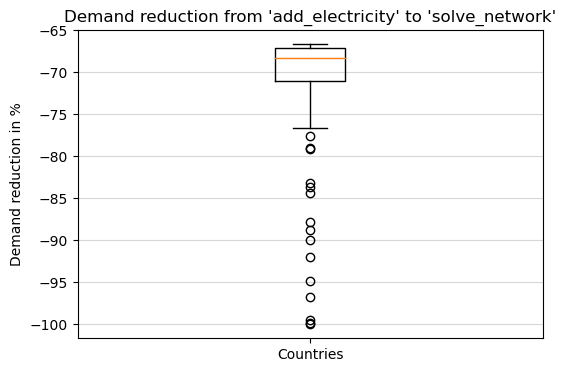

In [28]:
# Plot a boxplot to compare the difference in percent between the demand in "stats_demand" and "stats_demand_solve"
diff = ((stats_demand["demand_solve"] - stats_demand["demand_add_el"])/stats_demand["demand_add_el"]*100).dropna()
plt.figure(figsize=(6, 4))
plt.boxplot(diff)
plt.ylabel("Demand reduction in %")
plt.title("Demand reduction from 'add_electricity' to 'solve_network'")
plt.grid(axis='y', alpha=0.5)
plt.xticks([1], ["Countries"])
plt.show()

In [29]:
diff.describe()

count    143.000000
mean     -71.042593
std        7.080017
min     -100.000000
25%      -71.003185
50%      -68.345559
75%      -67.109822
max      -66.666667
dtype: float64

In [30]:
# Add continent at the beginning of the dataframe
stats_demand.insert(0, "continent", coco.convert(names = stats_demand.index, src = 'ISO2', to = 'continent'))

CP not found in ISO2
IC not found in ISO2
XS not found in ISO2
XD not found in ISO2


In [31]:
stats_demand.head()

,continent,demand_add_el,demand_solve
GR,Europe,6.396989e+07,2.024931e+07
KR,Asia,7.219712e+08,2.343130e+08
SZ,Africa,7.308368e+07,1.944323e+07
IL,Asia,8.872258e+07,1.987224e+07
ID,Asia,3.090736e+08,9.176958e+07


OWID

In [32]:
# Source: https://ourworldindata.org/grapher/electricity-demand?time=2022&country=USA~GBR~FRA~DEU~IND~BRA

In [33]:
owid_el_demand = pd.read_csv("notebooks/validation/temp_owid/electricity-demand.csv", index_col=0)

In [34]:
# Get Ember data only
ember_el_demand = owid_el_demand.loc[owid_el_demand.index.str.contains("Ember")]

# Select the year 2021
ember_el_demand = ember_el_demand[ember_el_demand["Year"] == 2021]

# Delete the string " (Ember)" contained in the indizes
ember_el_demand.index = ember_el_demand.index.str.replace(" \(Ember\)", "", regex=True)

In [35]:
# Sum up the rows "North America" and "Latin America and Caribbean" along the columns "Electricity demand (TWh)" to "America"
ember_el_demand.loc["America"] = ember_el_demand.loc["North America"] + ember_el_demand.loc["Latin America and Caribbean"]
# Set the Year of America to 2021
ember_el_demand.loc["America", "Year"] = 2021

In [36]:
ember_el_demand = ember_el_demand.loc[['Europe', 'Asia', 'Africa', 'Oceania', 'America']]

In [37]:
# Create new column continent
ember_el_demand.insert(0, "continent", ember_el_demand.index)

# Sort index alphabetically
ember_el_demand.sort_index(inplace=True)

In [38]:
ember_el_demand.head()

,continent,Code,Year,Electricity demand (TWh)
Entity,,,,
Africa,Africa,NaN,2021,839.35
America,America,NaN,2021,6481.32
Asia,Asia,NaN,2021,13783.52
Europe,Europe,NaN,2021,5134.72
Oceania,Oceania,NaN,2021,303.06


In [39]:
stats_demand_continent = stats_demand.groupby("continent").sum()/1e6 #convert from MWh to TWh

# drop row "not found"
stats_demand_continent.drop(index="not found", inplace=True)

In [40]:
stats_demand_continent.head(10)

,demand_add_el,demand_solve
continent,,
Africa,1655.346794,487.483281
America,7260.627548,2284.414860
Asia,16029.239598,5033.568237
Europe,4974.403331,1551.409970
Oceania,302.760792,88.960999


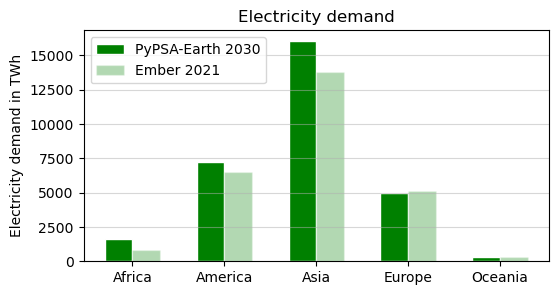

In [63]:
def plot_barplot_demand(stats_demand_continent, ember_el_demand, title=True):
    # Plot a barplot to compare the technologies of the two dataframes irena_eleccap and stats_capacities

    # Get the index values
    index = np.arange(len(stats_demand_continent))
    barWidth = 0.3

    # Create a barplot
    plt.figure(figsize=(6, 3))
    plt.bar(index - barWidth/2, stats_demand_continent, color=['g'], alpha=1, edgecolor='white', width=barWidth)
    plt.bar(index + barWidth/2, ember_el_demand, color=['g'], alpha=0.3, edgecolor='white', width=barWidth)

    # Enhance graph
    plt.xticks(index, stats_demand_continent.index)
    plt.ylabel("Electricity demand in TWh")
    plt.legend(["PyPSA-Earth 2030", "Ember 2021"], loc='upper left', ncol=1)

    plt.grid(axis='y', alpha=0.5)
    if title == True:
        plt.title(f"Electricity demand")

    # Show graphic & save it
    plt.savefig(f"notebooks/validation/temp_results/el_demand.pdf", bbox_inches='tight')
    plt.show()
    
    return

plot_barplot_demand(stats_demand_continent["demand_add_el"], ember_el_demand["Electricity demand (TWh)"], title=True)

In [42]:
stats_demand_continent["demand_add_el"]

continent
Africa      1655.346794
America     7260.627548
Asia       16029.239598
Europe      4974.403331
Oceania      302.760792
Name: demand_add_el, dtype: float64

In [43]:
ember_el_demand["Electricity demand (TWh)"]

Entity
Africa       839.35
America     6481.32
Asia       13783.52
Europe      5134.72
Oceania      303.06
Name: Electricity demand (TWh), dtype: float64

IEA

In [44]:
# Read the data from the excel file
iea_web = pd.read_excel("notebooks/validation/temp_IEA/World Energy Balances Highlights 2022.xlsx", sheet_name="TimeSeries_1971-2021", skiprows=1, index_col=0)

In [45]:
# filter the data, only "Total final consumption (PJ)" in the column "Flow" and "Electricity" in the column "Product" is required
iea_el_demand = iea_web[(iea_web["Flow"] == "Total final consumption (PJ)") & (iea_web["Product"] == "Electricity")]

# Get electricity demand of 2020 (most recent one available)
iea_el_demand = pd.DataFrame(iea_el_demand[2020]) * 0.277777778 #convert PJ to TWh 

In [46]:
# Change index entry "Non-OECD Asia (including China)" to "Non-OECD Asia (including C)" to avoid regex to match "China"
iea_el_demand.rename(index={"Non-OECD Asia (including China)": "Non-OECD Asia (including C)"}, inplace=True)

# Change country name to two digit country code and keep the old index where country_name_2_two_digits() returns "not found"
old_index = iea_el_demand.index.tolist()
new_index = iea_el_demand.index.map(country_name_2_two_digits) .tolist()

for i in range(len(new_index)):
    if new_index[i] == "not found":
        new_index[i] = old_index[i]

iea_el_demand.index = new_index

OECD Total not found in regex
Non-OECD Total not found in regex
Africa not found in regex
Non-OECD Americas not found in regex
Non-OECD Asia (including C) not found in regex
Non-OECD Europe and Eurasia not found in regex
Middle East not found in regex
IEA Total not found in regex
IEA and Accession/Association countries not found in regex
World not found in regex


In [47]:
iea_el_demand.head()

,2020
AU,216.685271
AT,61.203857
BE,79.0962
CA,523.041001
CL,74.514346


### Networks

In [48]:
# Select rule "add_electricity" and their techs 
stats_network = stats["base_network"].loc[:, ["lines_length", "lines_capacity"]]

In [49]:
# Add continent at the beginning of the dataframe
stats_network.insert(0, "continent", coco.convert(names = stats_network.index, src = 'ISO2', to = 'continent'))

CP not found in ISO2
IC not found in ISO2
XS not found in ISO2
XD not found in ISO2


In [50]:
stats_network.head()

key,continent,lines_length,lines_capacity
GR,Europe,20562.493806,3.721973e+05
KR,Asia,29380.942367,1.244128e+06
SZ,Africa,479.265806,8.579887e+03
IL,Asia,1473.808307,8.602230e+04
ID,Asia,49812.128350,9.034353e+05


GridKit

In [51]:
# Get GridKit data https://zenodo.org/record/47317#.ZBw1KvaZM-U. Manually downloaded and extracted.
gridkit_europe = pd.read_csv("notebooks/validation/temp_gridkit/gridkit_euorpe/gridkit_europe-highvoltage-links.csv")
gridkit_northamerica = pd.read_csv("notebooks/validation/temp_gridkit/gridkit_north_america/gridkit_north_america-highvoltage-links.csv")

In [52]:
gridkit_europe.head()

,l_id,v_id_1,v_id_2,voltage,cables,wires,frequency,name,operator,ref,length_m,r_ohmkm,x_ohmkm,c_nfkm,i_th_max_a,from_relation,wkt_srid_4326
0,22139,43193,23620,220000;132000,9,2,50,NaN,ATEL; BKW,NaN,489.727561,NaN,NaN,NaN,NaN,NaN,"SRID=4326;LINESTRING(7.61602141237887 47.2325986006218,7.617904680..."
1,65908,42022,13686,750000,3;1;1;1;3,4;4;4;4,NaN,750 kV,NaN,NaN,394971.083012,NaN,NaN,NaN,NaN,NaN,"SRID=4326;LINESTRING(26.6449735029238 50.2962827672493,21.87104687..."
2,67370,6913,48526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10602.245828,NaN,NaN,NaN,NaN,NaN,"SRID=4326;LINESTRING(18.1844471738857 40.0160881556809,18.12270420..."
3,3868,35422,28973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2385.934530,NaN,NaN,NaN,NaN,NaN,"SRID=4326;LINESTRING(10.2724738664462 49.8806084854841,10.28449725..."
4,4982,7864,63104,225000,3,1,50,NaN,RTE,NaN,1449.986592,NaN,NaN,NaN,NaN,NaN,"SRID=4326;LINESTRING(3.80033661099728 45.0451075088105,3.783910580..."


In [53]:
gridkit_europe_length = gridkit_europe["length_m"].sum() / 1e3 # convert from m to km
gridkit_northamerica_length = gridkit_northamerica["length_m"].sum() / 1e3 # convert from m to km

In [54]:
gridkit_europe_length

312192.9372446346

In [55]:
gridkit_northamerica_length

387177.83038631844